# Baseline UNet training + prediction/submission


This is the notebook I cobbled together to wrap my head around this challenge.
I don't garuantee that the results are great, only that it works from end-to-end. 

It trains a basic UNet and makes a submission. 

It's based on these three notebooks: 

1. [3D U-Net : Training Only](https://www.kaggle.com/code/ahsuna123/3d-u-net-training-only)
2. [3D U-Net PyTorch Lightning distributed training](https://www.kaggle.com/code/zhuowenzhao11/3d-u-net-pytorch-lightning-distributed-training)
3. [3d-unet using 2d image encoder](https://www.kaggle.com/code/hengck23/3d-unet-using-2d-image-encoder/notebook)


I've pre-computed the input data and stored them as numpy arrays so they don't have to be extracted every time the notebooks is run. 

## Installing offline deps

As this is a code comp, there is no internet. 
So we have to do some silly things to get dependencies in here. 
Why is asciitree such a PITA? 

In [1]:
deps_path = '../input/czii-cryoet-dependencies'

In [2]:
! pip check


torch 2.5.1 has requirement sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3.


In [3]:
from typing import List, Tuple, Union
import numpy as np
import torch
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from dataset import *

## Define some helper functions


### Patching helper functions

These are mostly used to split large volumes into smaller ones and stitch them back together. 

In [4]:
def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    """
    Calculate the starting positions of patches along a single dimension
    with minimal overlap to cover the entire dimension.
    
    Parameters:
    -----------
    dimension_size : int
        Size of the dimension
    patch_size : int
        Size of the patch in this dimension
        
    Returns:
    --------
    List[int]
        List of starting positions for patches
    """
    if dimension_size <= patch_size:
        return [0]
        
    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)
    
    if n_patches == 1:
        return [0]
    
    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)
    
    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)
    
    return positions

def extract_3d_patches_minimal_overlap(arrays: List[np.ndarray], patch_size: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    """
    Extract 3D patches from multiple arrays with minimal overlap to cover the entire array.
    
    Parameters:
    -----------
    arrays : List[np.ndarray]
        List of input arrays, each with shape (m, n, l)
    patch_size : int
        Size of cubic patches (a x a x a)
        
    Returns:
    --------
    patches : List[np.ndarray]
        List of all patches from all input arrays
    coordinates : List[Tuple[int, int, int]]
        List of starting coordinates (x, y, z) for each patch
    """
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")
    
    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")
    
    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")
    
    m, n, l = shape
    patches = []
    coordinates = []
    
    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size)
    y_starts = calculate_patch_starts(n, patch_size)
    z_starts = calculate_patch_starts(l, patch_size)
    
    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))
    
    return patches, coordinates

# Note: I should probably averge the overlapping areas, 
# but here they are just overwritten by the most recent one. 

def reconstruct_array(patches: List[np.ndarray], 
                     coordinates: List[Tuple[int, int, int]], 
                     original_shape: Tuple[int, int, int]) -> np.ndarray:
    """
    Reconstruct array from patches.
    
    Parameters:
    -----------
    patches : List[np.ndarray]
        List of patches to reconstruct from
    coordinates : List[Tuple[int, int, int]]
        Starting coordinates for each patch
    original_shape : Tuple[int, int, int]
        Shape of the original array
        
    Returns:
    --------
    np.ndarray
        Reconstructed array
    """
    reconstructed = np.zeros(original_shape, dtype=np.int64)  # To track overlapping regions
    
    patch_size = patches[0].shape[0]
    
    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] = patch
        
    
    return reconstructed

## Submission helper functions

These help with getting the submission in the correct format

In [5]:
import pandas as pd

def dict_to_df(coord_dict, experiment_name):
    """
    Convert dictionary of coordinates to pandas DataFrame.
    
    Parameters:
    -----------
    coord_dict : dict
        Dictionary where keys are labels and values are Nx3 coordinate arrays
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['x', 'y', 'z', 'label']
    """
    # Create lists to store data
    all_coords = []
    all_labels = []
    
    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)
    
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })

    
    return df

## Reading in the data

In [6]:
TRAIN_DATA_DIR = "../input/create-numpy-dataset-exp-name"
TEST_DATA_DIR = "../input/czii-cryo-et-object-identification"
valid_dir = '../input/czii-cryo-et-object-identification/train'

In [13]:
train_names = ['TS_6_4']
valid_names = ['TS_6_4']

train_files = []
valid_files = []

for name in train_names:
    image = read_one_data(name, static_dir=f'{valid_dir}/static/ExperimentRuns')
    label = np.load(f"../input/mask/generated{name}_mask.npz")
    label = label['arr_0']
    label = label[0]

    train_files.append({"image": image, "label": label})
    

for name in valid_names:
    image = read_one_data(name, static_dir=f'{valid_dir}/static/ExperimentRuns')
    label = np.load(f"../input/mask/generated{name}_mask.npz")
    label = label['arr_0']
    label = label[0]

    valid_files.append({"image": image, "label": label})
    


In [8]:
import cc3d
from dataset import *
from czii_helper import dotdict

def probability_to_location(probability,cfg):
    _,D,H,W = probability.shape

    location={}
    for p in PARTICLE:
        p = dotdict(p)
        l = p.label

        cc, P = cc3d.connected_components(probability[l]>cfg.threshold[p.name], return_N=True)
        stats = cc3d.statistics(cc)
        zyx=stats['centroids'][1:]*10
        xyz = np.ascontiguousarray(zyx[:,::-1]) 
        location[p.name]=xyz
        '''
            j=1
            z,y,x = np.where(cc==j)
            z=z.mean()
            y=y.mean()
            x=x.mean()
            print([x,y,z])
        '''
    return location

def location_to_df(location):
    location_df = []
    for p in PARTICLE:
        p = dotdict(p)
        xyz = location[p.name]
        if len(xyz)>0:
            df = pd.DataFrame(data=xyz, columns=['x','y','z'])
            #df.loc[:,'particle_type']= p.name
            df.insert(loc=0, column='particle_type', value=p.name)
            location_df.append(df)
    if location_df:
        location_df = pd.concat(location_df)
    else:
        location_df = pd.DataFrame()
        print("location_df is empty, returning an empty DataFrame.")
    return location_df

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    #'/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
       "../analyze/model.pth",
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    },
)

from scipy.optimize import linear_sum_assignment

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score

def printCV(valid_id,cfg,net):
    net.output_type = ['infer']
    submit_df = []
    net.eval()
    volume = read_one_data(valid_id[0], static_dir=f'{valid_dir}/static/ExperimentRuns')
    D, H, W = volume.shape
    probability = np.zeros((7, D, H, W), dtype=np.float32)
    count = np.zeros((7, D, H, W), dtype=np.float32)
    pad_volume = np.pad(volume, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)

    num_slice = 32
    zz = list(range(0, D - num_slice, num_slice // 2)) + [D - num_slice]

    for z in zz:
        print('\r', f'z:{z}', end='', flush=True)
        image = pad_volume[z:z + num_slice]
        batch = dotdict(
            image=torch.from_numpy(image).unsqueeze(0),
        )
        with torch.amp.autocast('cuda', enabled=True):
            with torch.no_grad():
                output = net(batch)
        prob = output['particle'][0].cpu().numpy()
        probability[:, z:z + num_slice] += prob[:, :, :H, :W]
        count[:, z:z + num_slice] += 1
    probability = probability / (count + 0.0001)
    location = probability_to_location(probability, cfg)
    df = location_to_df(location)
    df.insert(loc=0, column='experiment', value=valid_id[0])
    submit_df.append(df)

    num_volume = len(valid_id)
    submit_df = pd.concat(submit_df)

    submit_df.insert(loc=0, column='id', value=np.arange(len(submit_df)))
    
    gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')

    print(gb)
    print('lb_score:', lb_score)

    net.train()
    net.output_type = ['infer', 'loss']
    return probability

def visualize_and_save(valid_id,output, save_path="output_plot.png", title_prefix="Image",show=True,index=0):
    data_id = valid_names[0]
    volume = read_one_data(valid_id[0], static_dir=f'{valid_dir}/static/ExperimentRuns')
    mask = np.load(f'../input/mask/train_label_{data_id}.npy')

    volume = volume[index]
    mask = mask[index]
    
    # プロットの設定
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2行4列のグリッドを作成
    axes = axes.ravel()  # 2D配列を1Dに変換して簡単にインデックスを操作できるようにする

    for i in range(7):  # 最大7つの画像をプロット
        ax = axes[i]  # 現在の軸を取得
        img = output[i][index] # データを取得
        im = ax.imshow(img, cmap='GnBu')  # データをプロット
        ax.set_title(f"{title_prefix} {i+1}")  # 各プロットにタイトルを付ける
        plt.colorbar(im, ax=ax)  # 各軸にカラーバーを追加
    
    #8枚目を画像とそのマスクで追加
    ax = axes[7]
    img = volume
    im = ax.imshow(img, cmap='GnBu')  # データをプロット
    #マスクを重ねる
    mask = mask.astype(np.float32)
    mask[mask==0] = np.nan
    im = ax.imshow(mask, cmap='Reds', alpha=0.5)  # データをプロット
    ax.set_title(f"{title_prefix} {7+1}")  # 各プロットにタイトルを付ける
    plt.colorbar(im, ax=ax)  # 各軸にカラーバーを追加


    # 空のプロット（8個目が存在しない場合）を非表示にする
    if len(axes) > 7:
        axes[7].axis('off')

    plt.tight_layout()  # プロットのレイアウトを自動調整

    # 画像を保存
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # 高解像度で保存
    print(f"Plot saved to {save_path}")

    #if show == True:
    #    plt.show()

### Create the training dataloader

I should probably find a way to create a dataloader that takes more batches. 

In [16]:
from monai.transforms import Compose, RandCropByLabelClassesd, EnsureTyped, RandAxisFlipd, SpatialPadd
from monai.data import Dataset, DataLoader, CacheDataset
import torch

# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

raw_train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

my_num_samples = 1
train_batch_size = 1

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[32, 630, 630],  # 切り取りサイズ
        num_classes=7,
        num_samples=my_num_samples,
    ),
    SpatialPadd(
        keys=["image", "label"],
        spatial_size=(32, 640, 640),
        method="symmetric",  # 中心的なパディング
        mode="constant",  # パディング値
    ),
    RandAxisFlipd(
        keys=["image", "label"],
        prob=0.5,
    ),
    RandFlipd(
        keys=["image", "label"],
        prob=0.5,
        spatial_axis=[1]
    ),
    EnsureTyped(keys=["image", "label"]),
])

train_ds = Dataset(data=raw_train_ds, transform=random_transforms)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)


Loading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


In [ ]:
aaa

/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 3 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 4 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 5 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/monai/transfo

ユニークな画像の数: 1


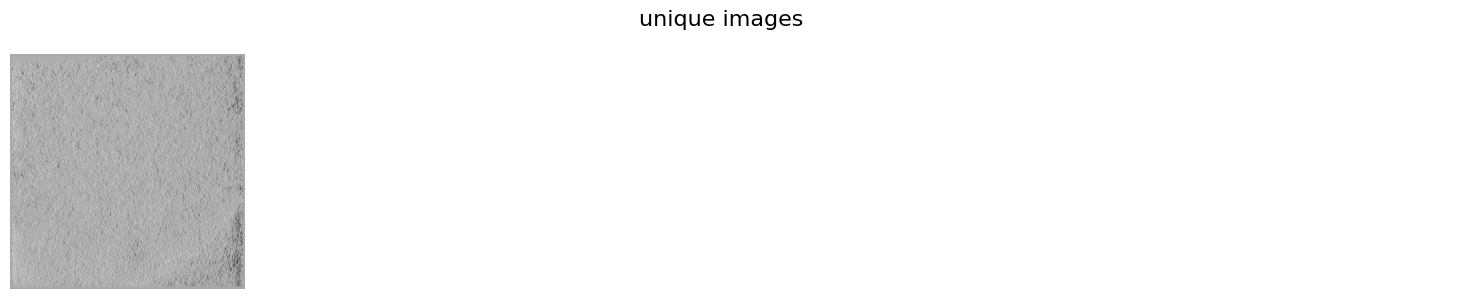

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import Compose, RandCropByLabelClassesd, EnsureTyped, Resized
from monai.data import Dataset, CacheDataset, DataLoader
from monai.utils import set_determinism

# 再現性のための設定
set_determinism(seed=16)

# ユニークな画像を保存するリスト（バイト列ではなくテンソルで保持する）
unique_images = []

# データローダーからユニークな画像を取得する関数
def collect_unique_images(data_loader):
    global unique_images
    unique_hashes = set()  # 重複を防ぐためのハッシュセット
    for batch in data_loader:
        images = batch["image"]  # 画像テンソルを取得
        for image in images:
            img_hash = hash(image.numpy().tobytes())  # ユニーク性を判定するためにハッシュ化
            if img_hash not in unique_hashes:
                unique_hashes.add(img_hash)
                unique_images.append(image.numpy())  # ユニーク画像をリストに保存

# ユニーク画像をグリッド形式で表示する関数
def display_images(images, num_cols=5, title="unique images"):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # 必要な行数を計算
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            image = images[idx]
            image = image[0, 15, :, :]  # 形状 (1, 32, 630, 630) -> (630, 630)
            ax.imshow(image, cmap="gray")
            ax.axis("off")
        else:
            ax.axis("off")  # 空白のプロット領域

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# データローダーから画像を収集して表示
collect_unique_images(train_loader)
print(f"ユニークな画像の数: {len(unique_images)}")
display_images(unique_images, num_cols=5, title="unique images")


/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 3 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 4 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 5 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/monai/transfo

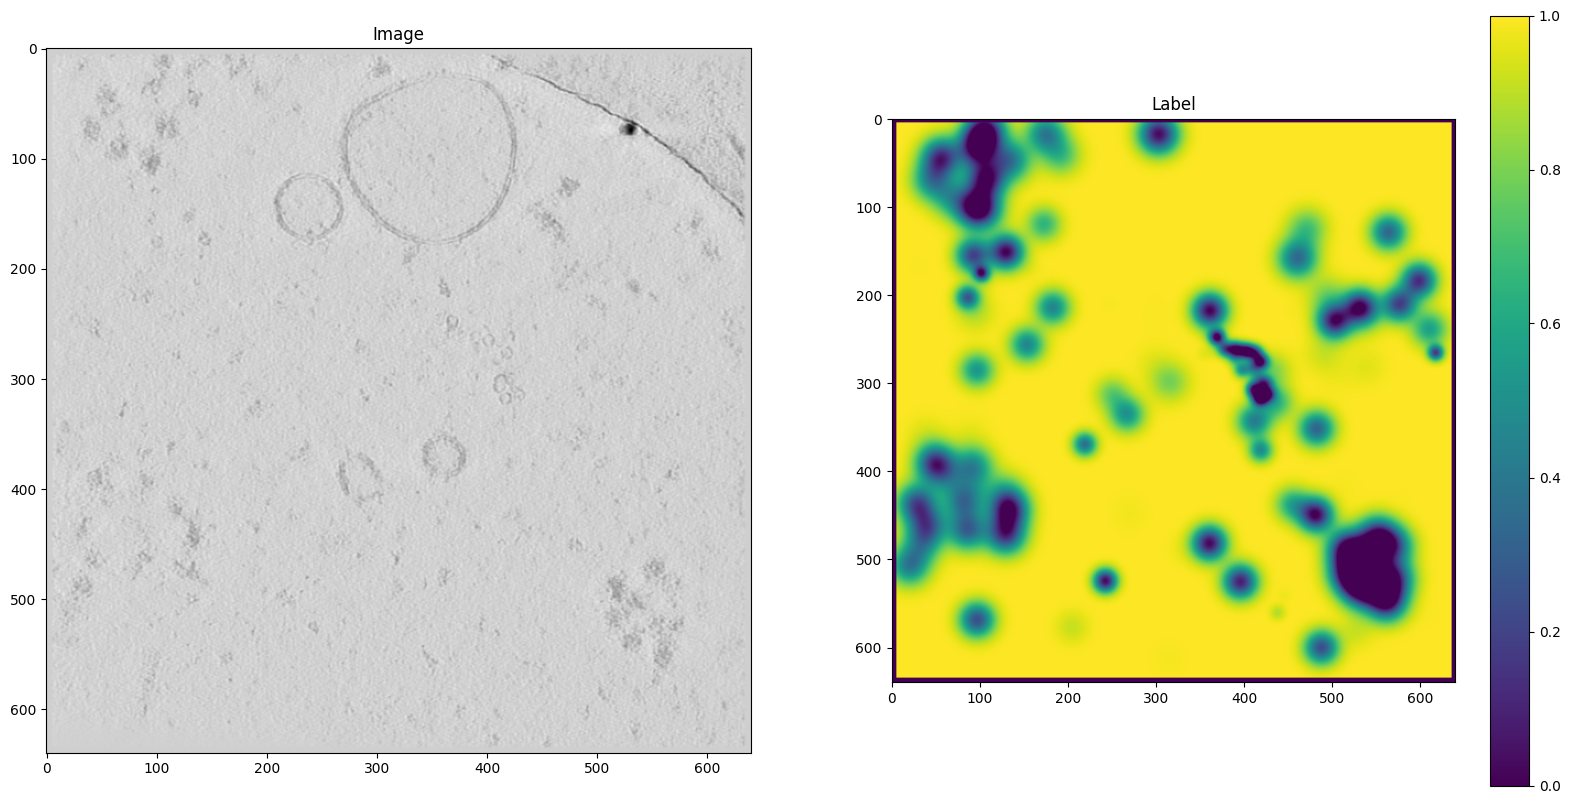

In [21]:
batch = next(iter(train_loader))
#画像を並べて表示
n = 0
n = n + 1
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(batch["image"][0, 0, n, :, :], cmap='gray')
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(batch["label"][0, 0, n, :, :])
plt.colorbar()
plt.title("Label")
plt.show()

In [12]:
batch["image"].shape

torch.Size([1, 1, 32, 640, 640])

In [13]:
from model2_for12 import Net,run_check_net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch["image"] = batch["image"].squeeze(1).to(device)
batch["label"] = batch["label"].squeeze(1).long().to(device)

net = Net(pretrained=False,cfg=cfg).to(device)
net.output_type = ['infer','loss']

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

for i  in range(100):
    net.train()
    with torch.amp.autocast('cuda', enabled=True):
        optimizer.zero_grad()
        output = net(batch)

    loss = output['mask_loss']
    for k, v in output.items():
        if 'loss' in k:
            print(f'{k:>32} : {v.item()} ')  

    loss.backward()
    optimizer.step()


                       mask_loss : 1.6744636297225952 
                       mask_loss : 1.6479095220565796 
                       mask_loss : 1.6233739852905273 
                       mask_loss : 1.6031901836395264 
                       mask_loss : 1.5868667364120483 
                       mask_loss : 1.5739065408706665 
                       mask_loss : 1.5636701583862305 
                       mask_loss : 1.555494785308838 
                       mask_loss : 1.549034833908081 
                       mask_loss : 1.544068455696106 
                       mask_loss : 1.5401701927185059 
                       mask_loss : 1.5369584560394287 
                       mask_loss : 1.5342520475387573 
                       mask_loss : 1.5319689512252808 
                       mask_loss : 1.5302523374557495 
                       mask_loss : 1.5291296243667603 
                       mask_loss : 1.5278353691101074 
                       mask_loss : 1.5271024703979492 
             

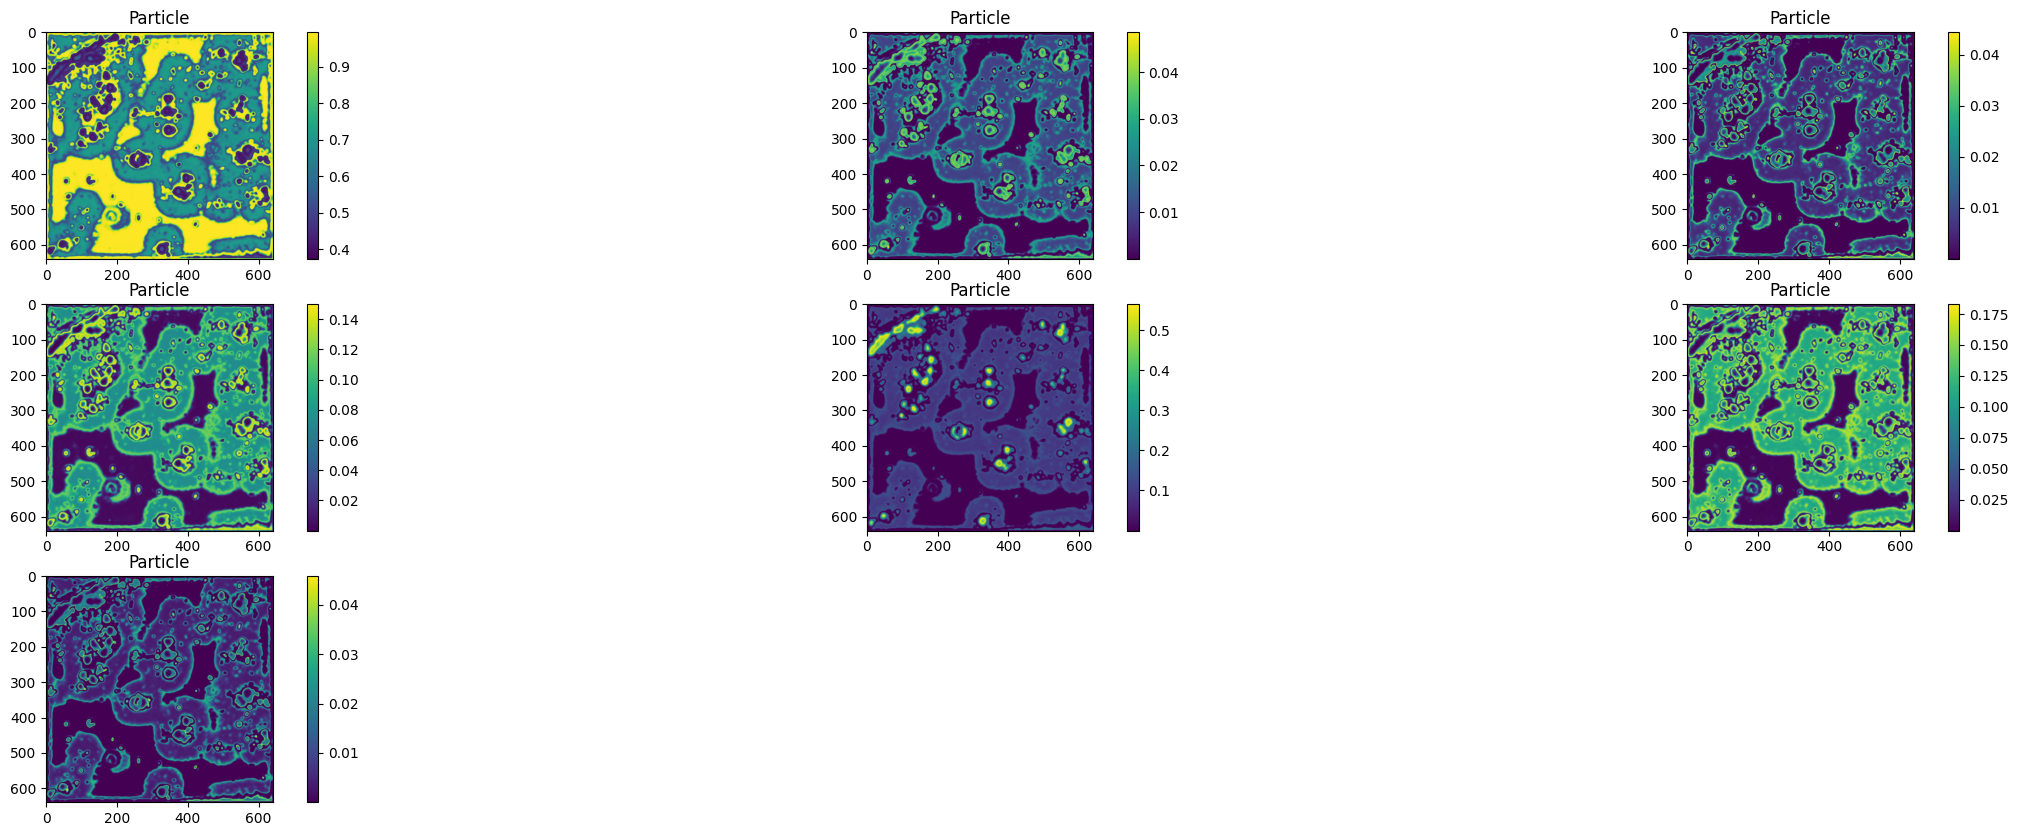

: 

In [ ]:
#output['particle']の可視化
plt.figure(figsize=(30, 10))

img = {}
img['particle'] = output['particle'].detach().cpu().numpy()


for i in range(7):
    plt.subplot(3, 3, i+1)
    plt.imshow(img['particle'][0, i, 15, :, :])
    plt.title("Particle")
    plt.colorbar()

In [15]:
aaa

NameError: name 'aaa' is not defined

## Train the model



In [14]:
from model2_for10 import Net,run_check_net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = Net(pretrained=True,cfg=cfg)

cuda


In [ ]:
net.output_type = ['infer','loss']
net = net.to(device)
# パラメータ設定
num_epochs = 400 # エポック数
learning_rate = 1e-3# 学習率
model_save_path = '../model/model1.pth'  # 最終モデル保存ファイル

optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for batch in train_loader:

        batch["image"] = batch["image"].squeeze(1).to(device)
        batch["label"] = batch["label"].squeeze(1).long().to(device)
        with torch.amp.autocast('cuda', enabled=True):
            optimizer.zero_grad()
            outputs = net(batch)
            loss = outputs['mask_loss']
        
        for k, v in outputs.items():
            if 'loss' in k:
                print(f'{k:>32} : {v.item()} ')    
        
        loss.backward()
        
        max_norm = 1.0
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm)


        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

    if epoch % 25 == 0:
        tmp = printCV(valid_names,cfg,net)
        visualize_and_save(valid_names,tmp, save_path=f"image/{epoch}.png", title_prefix="Image",show=True,index=62)

torch.save(net.state_dict(), model_save_path)
print("Model saved to", model_save_path)


Let there be gradients!

Locally this config seems to train for about 1000 steps before the model starts overfitting. 

## Predict on the test set



In [15]:
model.eval();
model.to("cuda");

In [16]:
import json
copick_config_path = TRAIN_DATA_DIR + "/copick.config"

with open(copick_config_path) as f:
    copick_config = json.load(f)

copick_config['static_root'] = '../input/czii-cryo-et-object-identification/test/static'

copick_test_config_path = 'copick_test.config'

with open(copick_test_config_path, 'w') as outfile:
    json.dump(copick_config, outfile)

In [17]:
import copick

root = copick.from_file(copick_test_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

In [18]:
# Non-random transforms to be cached
inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS")
])

In [19]:
import cc3d

id_to_name = {1: "apo-ferritin", 
              2: "beta-amylase",
              3: "beta-galactosidase", 
              4: "ribosome", 
              5: "thyroglobulin", 
              6: "virus-like-particle"}

### Iterate over test set


Below we will: 
1. Read in a run
2. Split it into patches of size (96, 96, 96)
3. Create a dataset from the patches
4. Predict the segmentation mask
5. Glue the mask back together
6. Find the connected components for each class
7. Find the centroids of the connected components
8. Add to the dataframe

Then do this for all runs. 

This can probably be optimized quite a bit. 

In [ ]:
BLOB_THRESHOLD = 500
CERTAINTY_THRESHOLD = 0.5

classes = [1, 2, 3, 4, 5, 6]
with torch.no_grad():
    location_df = []
    for run in root.runs:
        print(run)

        tomo = run.get_voxel_spacing(10)
        tomo = tomo.get_tomogram(tomo_type).numpy()



        tomo_patches, coordinates  = extract_3d_patches_minimal_overlap([tomo], 96)

        tomo_patched_data = [{"image": img} for img in tomo_patches]

        tomo_ds = CacheDataset(data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0)

        pred_masks = []

        for i in range(len(tomo_ds)):
            input_tensor = tomo_ds[i]['image'].unsqueeze(0).to("cuda")
            model_output = model(input_tensor)

            probs = torch.softmax(model_output[0], dim=0)
            thresh_probs = probs > CERTAINTY_THRESHOLD
            _, max_classes = thresh_probs.max(dim=0)

            pred_masks.append(max_classes.cpu().numpy())
            

        reconstructed_mask = reconstruct_array(pred_masks, coordinates, tomo.shape)
        
        location = {}

        for c in classes:
            cc = cc3d.connected_components(reconstructed_mask == c)
            stats = cc3d.statistics(cc)
            zyx=stats['centroids'][1:]*10.012444 #https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895#3040071
            zyx_large = zyx[stats['voxel_counts'][1:] > BLOB_THRESHOLD]
            xyz =np.ascontiguousarray(zyx_large[:,::-1])

            location[id_to_name[c]] = xyz


        df = dict_to_df(location, run.name)
        location_df.append(df)
    
    location_df = pd.concat(location_df)

In [21]:
location_df.insert(loc=0, column='id', value=np.arange(len(location_df)))
location_df.to_csv("submission.csv", index=False)

In [ ]:
!ls

In [23]:
!cp -r ../input/hengck-czii-cryo-et-01/* .

In [24]:
from czii_helper import *
from dataset import *
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

In [ ]:
import os
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    MODE = 'submit'
else:
    MODE = 'local'







valid_dir ='../input/czii-cryo-et-object-identification/train'
valid_id = ['TS_6_4', ]

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0